In [1]:
# import libaries:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import random

DATA_PATH ='/Users/my_computer/Desktop/data science and machone learning/SLAM course/VAN_ex/dataset/sequences/05/'

def read_images(idx):
 img_name = '{:06d}.png'.format(idx)
 img1 = cv2.imread(DATA_PATH+'image_0/'+img_name, 0)
 img2 = cv2.imread(DATA_PATH+'image_1/'+img_name, 0)
 return img1, img2

img1,img2 = read_images(0)

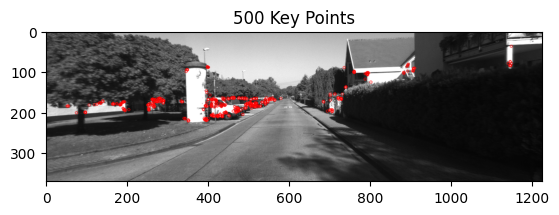

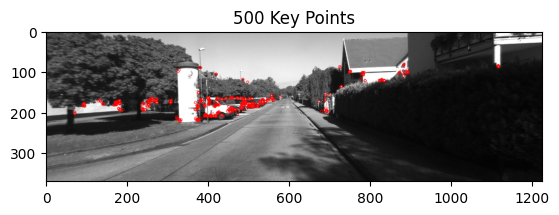

In [2]:
# Section 1.1: 
# Detect and extract at least 500 key-points on each image:
def detect_and_extract_key_points(img,num_of_keys):
    orb = cv2.ORB_create(nfeatures = num_of_keys)
    kp = orb.detect(img,None)
    img_with_keypoints = cv2.drawKeypoints(img,kp,None,color=(255,0,0), flags = 0 )
    kp,des = orb.compute(img,kp)
    plt.imshow(img_with_keypoints)
    plt.title(f'{num_of_keys} Key Points')
    plt.show()
    return des,kp

num_of_keys = 500
des1,kp1 = detect_and_extract_key_points(img1,num_of_keys)
des2,kp2 = detect_and_extract_key_points(img2,num_of_keys)

In [ ]:
# Section 1.2:
# Print the descriptors of the two first features:
#img1:
print('Image 1 first two descriptors features:\n',des1[0:2])

print('------------------')
#img2:
print('Image 2 first two descriptors features:\n',des2[0:2])

Image 1 first two descriptors features:
 [[144  88 186 245  38  66 189 230  60 130 114 163 189 191  33   0 174 127
   19 193  96 191 146 106 225 167 126 128 109 112  39 187]
 [252 105 204 164 172  75  95 136 131 182 148 169 211  15  83  27  72 212
  253  99  72  71 203 128 242 193 229 189  36 185 222   2]]
------------------
Image 2 first two descriptors features:
 [[216 250  59 234  48 141  91 112 172   8 177 108 191 215 169  80 182 185
   93  98 195  39 136  95 240 249  34 184  24 131  35  43]
 [ 65 145 105 109  80  78  99  57 100 104 251 236 147  55 128 112 124 156
   94 236 137 154 245  13 229 172 162 196  96 162 103 249]]


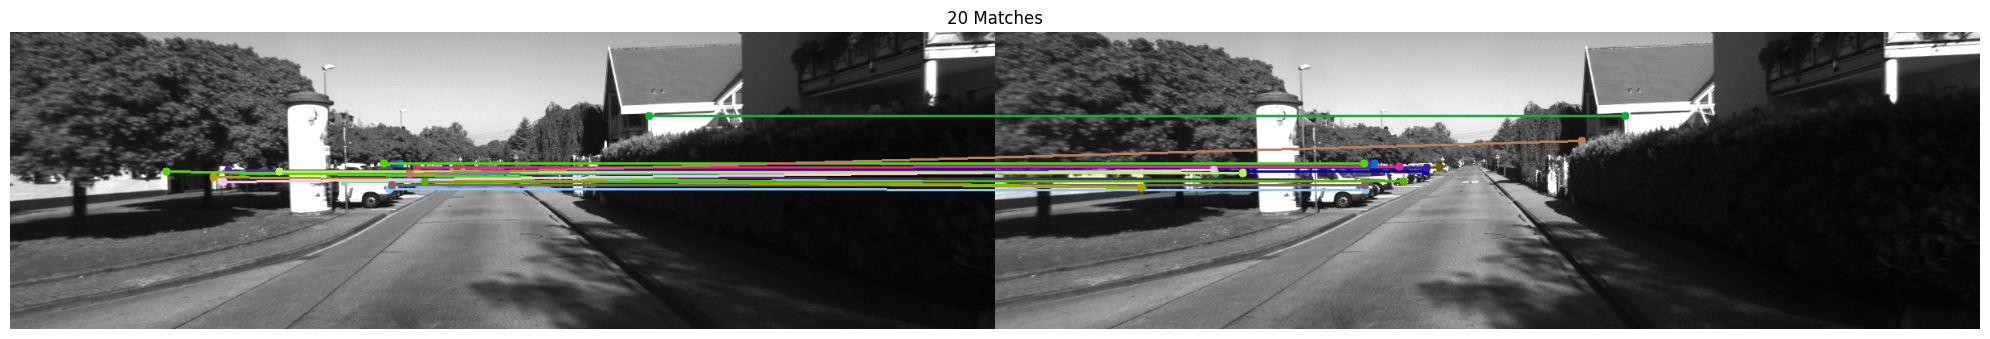

In [4]:
# Section 1.3:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des1, des2,k=2)
matches = matches[:20]
match_img = cv2.drawMatches(img1, kp1, img2, kp2, [], None, flags=2)
h1, w1 = img1.shape
h2, w2 = img2.shape
offset = w1  
match_img = cv2.cvtColor(match_img, cv2.COLOR_GRAY2BGR) if len(match_img.shape) == 2 else match_img

for m, n in matches:  
    best_match = m  
    color = tuple(random.randint(0, 255) for _ in range(3))
    pt1 = tuple(np.round(kp1[best_match.queryIdx].pt).astype(int))
    pt2 = tuple(np.round(kp2[best_match.trainIdx].pt).astype(int) + np.array([offset, 0]))
    cv2.line(match_img, pt1, pt2, color, thickness=2)
    cv2.circle(match_img, pt1, 5, color, thickness=-1)
    cv2.circle(match_img, pt2, 5, color, thickness=-1)
    
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title("20 Matches")
plt.axis("off")
plt.tight_layout()
plt.show()


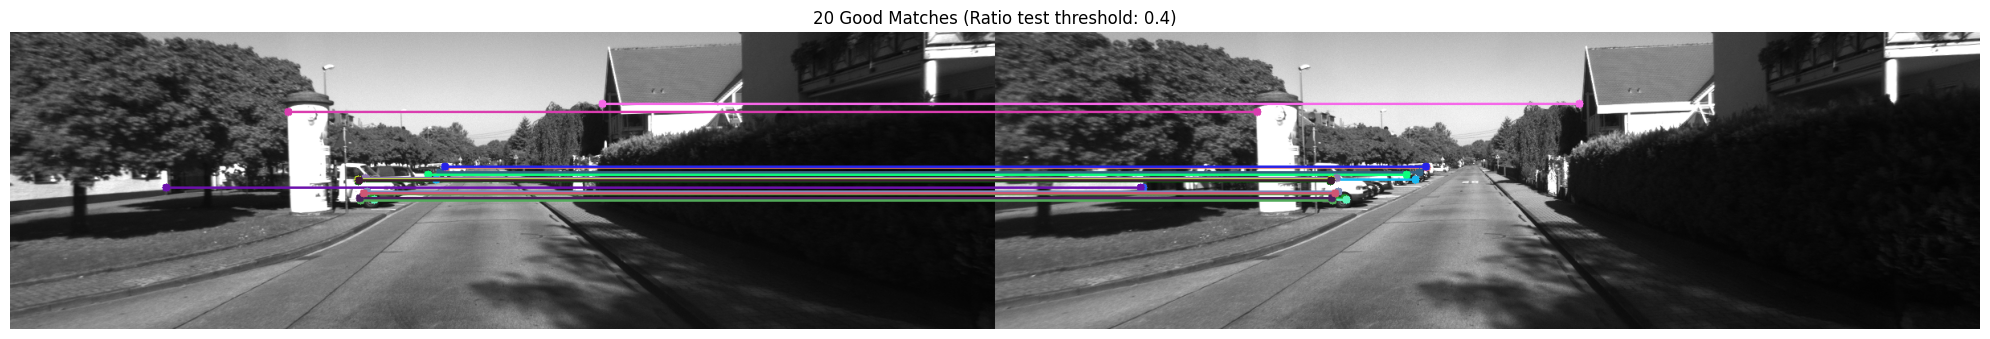

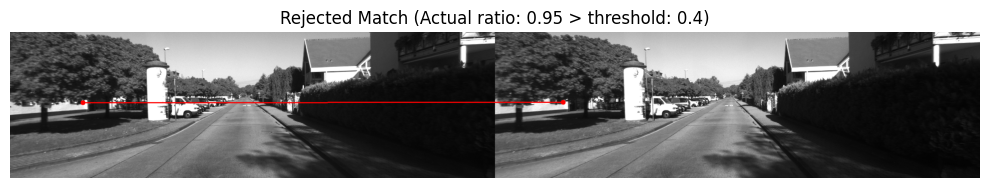

Ratio threshold used: 0.4
Total matches: 500
Good matches: 24
Rejected matches: 476


In [11]:
# Section 1.4: 
ratio_thresh = 0.4
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches_knn = bf.knnMatch(des1, des2, k=2)
good_matches = []
bad_matches = []

for m, n in matches_knn:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)
    else:
        bad_matches.append((m, n))  
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
offset = w1 
output_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
output_img[:h1, :w1] = img1 if img1.ndim == 3 else cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
output_img[:h2, w1:] = img2 if img2.ndim == 3 else cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

for match in good_matches[:20]:
    color = tuple(random.randint(0, 255) for _ in range(3))
    pt1 = tuple(np.round(kp1[match.queryIdx].pt).astype(int))
    pt2 = tuple(np.round(kp2[match.trainIdx].pt).astype(int) + np.array([offset, 0]))
    cv2.line(output_img, pt1, pt2, color, 2)
    cv2.circle(output_img, pt1, 5, color, -1)
    cv2.circle(output_img, pt2, 5, color, -1)

# Display 20 good matches
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title(f"20 Good Matches (Ratio test threshold: {ratio_thresh})")
plt.axis("off")
plt.tight_layout()
plt.show()

# Draw one rejected match
base_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
base_img[:h1, :w1] = img1 if img1.ndim == 3 else cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
base_img[:h2, w1:] = img2 if img2.ndim == 3 else cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

m, n = random.choice(bad_matches)
actual_ratio = m.distance / n.distance
rejected_img = base_img.copy()
pt1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
pt2 = tuple(np.round(kp2[m.trainIdx].pt).astype(int) + np.array([offset, 0]))
cv2.line(rejected_img, pt1, pt2, (0, 0, 255), 2)
cv2.circle(rejected_img, pt1, 6, (0, 0, 255), -1)
cv2.circle(rejected_img, pt2, 6, (0, 0, 255), -1)
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(rejected_img, cv2.COLOR_BGR2RGB))
plt.title(f"Rejected Match (Actual ratio: {actual_ratio:.2f} > threshold: {ratio_thresh})")
plt.axis("off")
plt.tight_layout()
plt.show()
print(f"Ratio threshold used: {ratio_thresh}")
print(f"Total matches: {len(matches_knn)}")
print(f"Good matches: {len(good_matches)}")
print(f"Rejected matches: {len(bad_matches)}")
